In [23]:
import matplotlib.pyplot as plt 
import numpy as np
from copy import deepcopy

%matplotlib inline
plt.rcParams['font.size'] = 16

import qiskit
from qiskit.ignis.measurement.discriminator.iq_discrimination import \
    LinearIQDiscriminator, QuadraticIQDiscriminator
from qiskit.result.models import ExperimentResultData
from qiskit import IBMQ

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

In [34]:
account_provider = IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

/home/daniel/anaconda3/envs/PulseDev/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [3]:
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_20_tokyo')
back_config = backend.configuration().to_dict()
device = pulse.PulseChannelSpec.from_backend(backend)

In [4]:
defaults = backend.defaults()

# command definition from defaults.
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

In [5]:
qubits = [0, 1]
schedules = []
meas_buffer = 2
shots = 512

meas = cmd_def.get('measure', qubits=tuple(range(20)))

# Create a calibration schedule for the ground state.
schedule_no_pi = pulse.Schedule(name='cal_00')
schedule_no_pi += meas

# Create a calibration schedule for the excited state.
schedule_pi = pulse.Schedule(name='cal_11')
for q in qubits:
    xgate = cmd_def.get('x', qubits=q)
    schedule_pi += xgate

schedule_pi += meas << (schedule_pi.duration + meas_buffer)

# Measurement schedule. Do an X90p gate on both qubits.
schedule_x90p = pulse.Schedule(name='X90p')
for q in qubits:
    x90p = cmd_def.get('u3', qubits=q, P0=np.pi/2., P1=0., P2=0.)
    schedule_x90p += x90p
    
schedule_x90p += meas << (schedule_x90p.duration + meas_buffer)
    
schedules = [schedule_no_pi, schedule_pi, schedule_x90p]

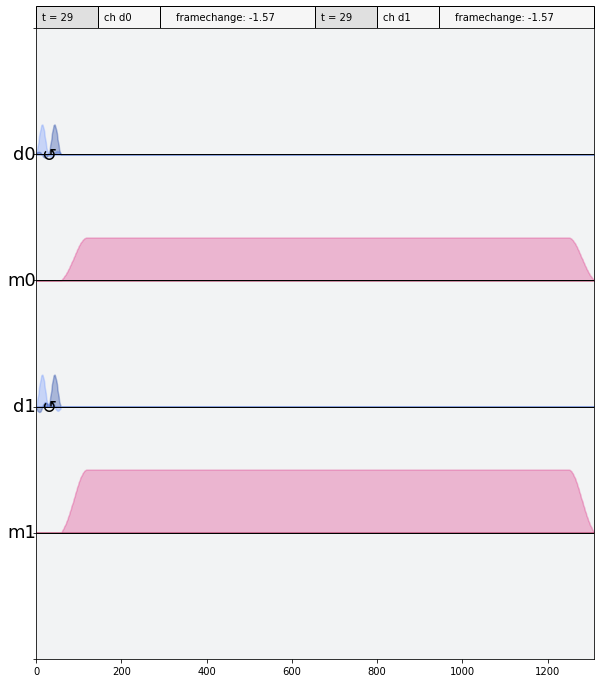

In [6]:
plt_chs = []
for q in [0, 1]:
    plt_chs.append(device.qubits[q].measure)
    plt_chs.append(device.qubits[q].drive)
    # plt_chs.append(device.qubits[q].acquire)

schedules[2].draw(channels_to_plot=plt_chs, scaling=10.)

In [7]:
qobj = assemble(schedules, backend, meas_level=1, meas_return='single', shots=shots)

In [8]:
jobs = backend.jobs()

In [9]:
for j in jobs:
    if j.job_id() == '5d4d8bd6ec92720012540e43':
        job = j
        
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [10]:
# job = backend.run(qobj)

In [11]:
job.job_id()

'5d4d8bd6ec92720012540e43'

In [12]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [13]:
result = job.result(timeout=3600)

In [14]:
# Extract the cals from the result
# This could go in the discriminator!
def extract_cals(result, cal_names):

    new_result = deepcopy(result)

    new_results = []
    for res in new_result.results:
        if res.header.name in cal_names:
            new_results.append(res)

    new_result.results = new_results
    
    return new_result

def extract_cal_schedules(schedules, cal_names):
    
    cal_schedules = []
    
    for s in schedules:
        if s.name in cal_names:
            cal_schedules.append(s)
            
    return cal_schedules

In [15]:
cal_names = ['cal_00', 'cal_11']

In [16]:
cal_results = extract_cals(result, cal_names)

In [17]:
def get_iq_grid(xdata, qubit):
    max_i = np.max(xdata[:, qubit*2])
    min_i = np.min(xdata[:, qubit*2])
    max_q = np.max(xdata[:, qubit*2+1])
    min_q = np.min(xdata[:, qubit*2+1])
    
    spacing = (max_i - min_i) / 100.0
    xx, yy = np.meshgrid(np.arange(min_i-2*spacing, max_i+2*spacing, spacing), np.arange(min_q-2*spacing, max_q+2*spacing, spacing))

    return xx, yy

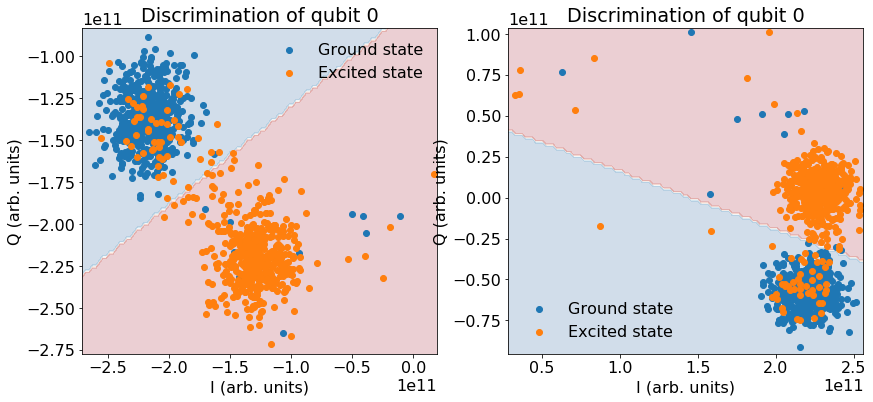

In [24]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 2, figsize=(14,6))

expected_states = [0, 1]

for q in [0, 1]:
    discriminator = LinearIQDiscriminator(cal_results, [q], ['0', '1'])
    
    xdata = np.array(discriminator.xdata)
    ydata = np.array(discriminator.ydata)

    cal00 = xdata[ydata == '0']
    cal11 = xdata[ydata == '1']

    q1_pi = xdata[ydata == '1']
    q1_nopi = xdata[ydata == '0']
    
    xx, yy = get_iq_grid(xdata, 0)
    
    Z = discriminator.discriminate(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.astype(float).reshape(xx.shape)
    ax[q].contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=.2)
    ax[q].scatter(cal00[:, 0], cal00[:, 1], label='Ground state')
    ax[q].scatter(cal11[:, 0], cal11[:, 1], label='Excited state')
    ax[q].legend(frameon=False)
    ax[q].set_xlabel('I (arb. units)')
    ax[q].set_ylabel('Q (arb. units)')
    ax[q].set_title('Discrimination of qubit {}'.format(q));

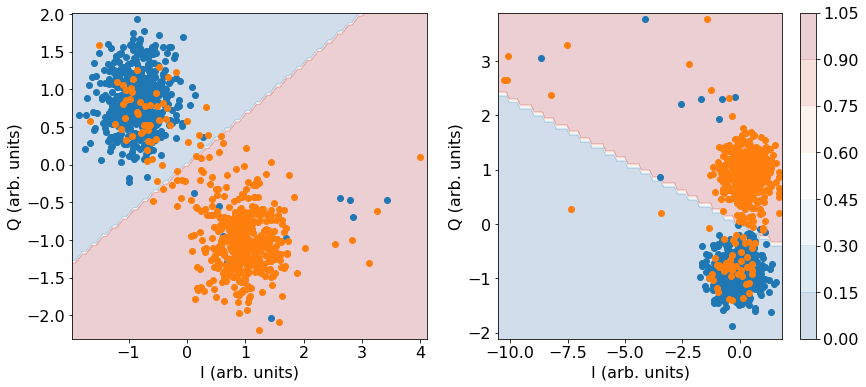

In [25]:
qubits = [0, 1]

discriminator = LinearIQDiscriminator(cal_results, qubits, ['00', '11'], standardize=True)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

xdata = np.array(discriminator.xdata)
ydata = np.array(discriminator.ydata)

cal00 = xdata[ydata == '00']
cal11 = xdata[ydata == '11']

for q in qubits:
    xx, yy = get_iq_grid(xdata, q)
    
    n = len(xx.ravel())
    
    if q == 0:
        iq_grid = np.c_[xx.ravel(), yy.ravel(), [0.0]*n, [0.0]*n]
    else:
        iq_grid = np.c_[[0.0]*n, [0.0]*n, xx.ravel(), yy.ravel()]
    
    Z = discriminator.discriminate(iq_grid)
    Z = np.where(Z=='11', '1', Z)  # replacement for plotting
    Z = Z.astype(float).reshape(xx.shape)
    cs = ax[q].contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=.2)
    q1_pi = result.get_memory('cal_00')[:, q]
    q1_nopi = result.get_memory('cal_11')[:, q]    
    ax[q].scatter(cal00[:, 2*q], cal00[:, 2*q+1], color='C0', label='Ground state')
    ax[q].scatter(cal11[:, 2*q], cal11[:, 2*q+1], color='C1', label='Excited state')
    ax[q].set_xlabel('I (arb. units)')
    ax[q].set_ylabel('Q (arb. units)')

cbar = fig.colorbar(cs)